<a href="https://colab.research.google.com/github/Rodolfoloc/Native-bees/blob/main/Code/YOLOv8_MOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Report errors and suggestions to rodolfo.leocadio@ufop.edu.br

##Initiation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path

Path('/content/Videos').mkdir(exist_ok=True)
Path('/content/Images').mkdir(exist_ok=True)

##Installations and Imports

In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

!git clone https://github.com/ifzhang/ByteTrack.git

%cd /content/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru
!pip install -q lap
!pip install -q thop

import yolox
print('yolox.__version__:', yolox.__version__)

import sys
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from math import trunc, sqrt
from collections import OrderedDict
from scipy.spatial import distance as dist
from yolox.tracker.byte_tracker import BYTETracker, STrack
from dataclasses import dataclass
from __future__ import annotations
from typing import Any, Iterator, List, Optional, Tuple, Union
from enum import Enum
from onemetric.cv.utils.iou import box_iou_batch

Ultralytics YOLOv8.0.123 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/78.2 GB disk)


fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/content/ByteTrack
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 100.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!

##YOLOv8

In [5]:
MODEL = "/content/drive/MyDrive/resultYv8/Train_300/weights/best.pt" #Models of your choice

In [6]:
model = YOLO(MODEL)
model.fuse()

Model summary (fused): 268 layers, 68124531 parameters, 0 gradients


In [7]:
def Y_Inference(SOURCE_IMAGE_PATH):
  results = model(SOURCE_IMAGE_PATH)

  xyxy = results[0].boxes.xyxy.cpu().numpy().astype(int)
  confidence = results[0].boxes.conf.cpu().numpy()
  class_id = results[0].boxes.cls.cpu().numpy().astype(int)

  return (xyxy, confidence, class_id)

In [8]:
def Draw_Image(COLORS, im, xyxy, confidence, class_id):
  for i in range(len(xyxy)):
    cor = (int(COLORS[0][0]), int(COLORS[0][1]), int(COLORS[0][2]))
    (x,y,w,h)= (xyxy[i][0], xyxy[i][1], xyxy[i][2] - xyxy[i][0], xyxy[i][3] - xyxy[i][1])
    #Caixas delimitadoras
    fundo = np.full((im.shape),(0,0,0),dtype = np.uint8)
    cv2.rectangle(im,(x,y),(x+w,y+h),cor,2)
	  #Id classe
    texto = '{}: {:.2f}'.format(CLASS_NAMES_DICT[class_id[i]],round(confidence[i],2))
    cv2.putText(fundo,texto,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
	  #Caixa do Id classe
    fx,fy,fw,fh = cv2.boundingRect(fundo[:,:,2])
    cv2.rectangle(im,(fx,fy),(fx+fw,fy+fh),cor,-1)
    cv2.rectangle(im,(fx,fy),(fx+fw,fy+fh),cor,3)
    cv2.putText(im,texto,(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
  return im

##Parameters

In [9]:
SOURCE_IMAGE_PATH = "/content/Images/0018-91270.png" #Images of your choice
TARGET_IMAGE_PATH = "/content/Images/result.png"

In [10]:
SOURCE_VIDEO_PATH = "/content/Videos/Te2.mp4" #Videos of your choice
TARGET_VIDEO_PATH = "/content/Videos/result.mp4"

In [11]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)
# class_ids of interest - Bee_J
CLASS_ID = [0]

{0: 'Bee_J'}


In [12]:
COLORS = np.random.randint(0,255,size = (len(CLASS_ID),3),dtype = 'uint8')

In [13]:
#Euclidian Tracking parameter
maxDisappeared = 20
#Optical flow parameter
threshold_dist = 120
#Byte Track parameters
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.05 #Track threshold = 0.3
    track_buffer: int = 20 #Track buffer = 500
    match_thresh: float = 1.0 #Match threshold = 0.8
    aspect_ratio_thresh: float = 3.0 #Aspect ratio threshold = 3.0
    min_box_area: float = 1.0
    mot20: bool = True #MOT = False

##YOLOv8 in images


image 1/1 /content/Images/0018-91270.png: 480x800 9 Bee_Js, 95.9ms
Speed: 15.8ms preprocess, 95.9ms inference, 21.7ms postprocess per image at shape (1, 3, 480, 800)


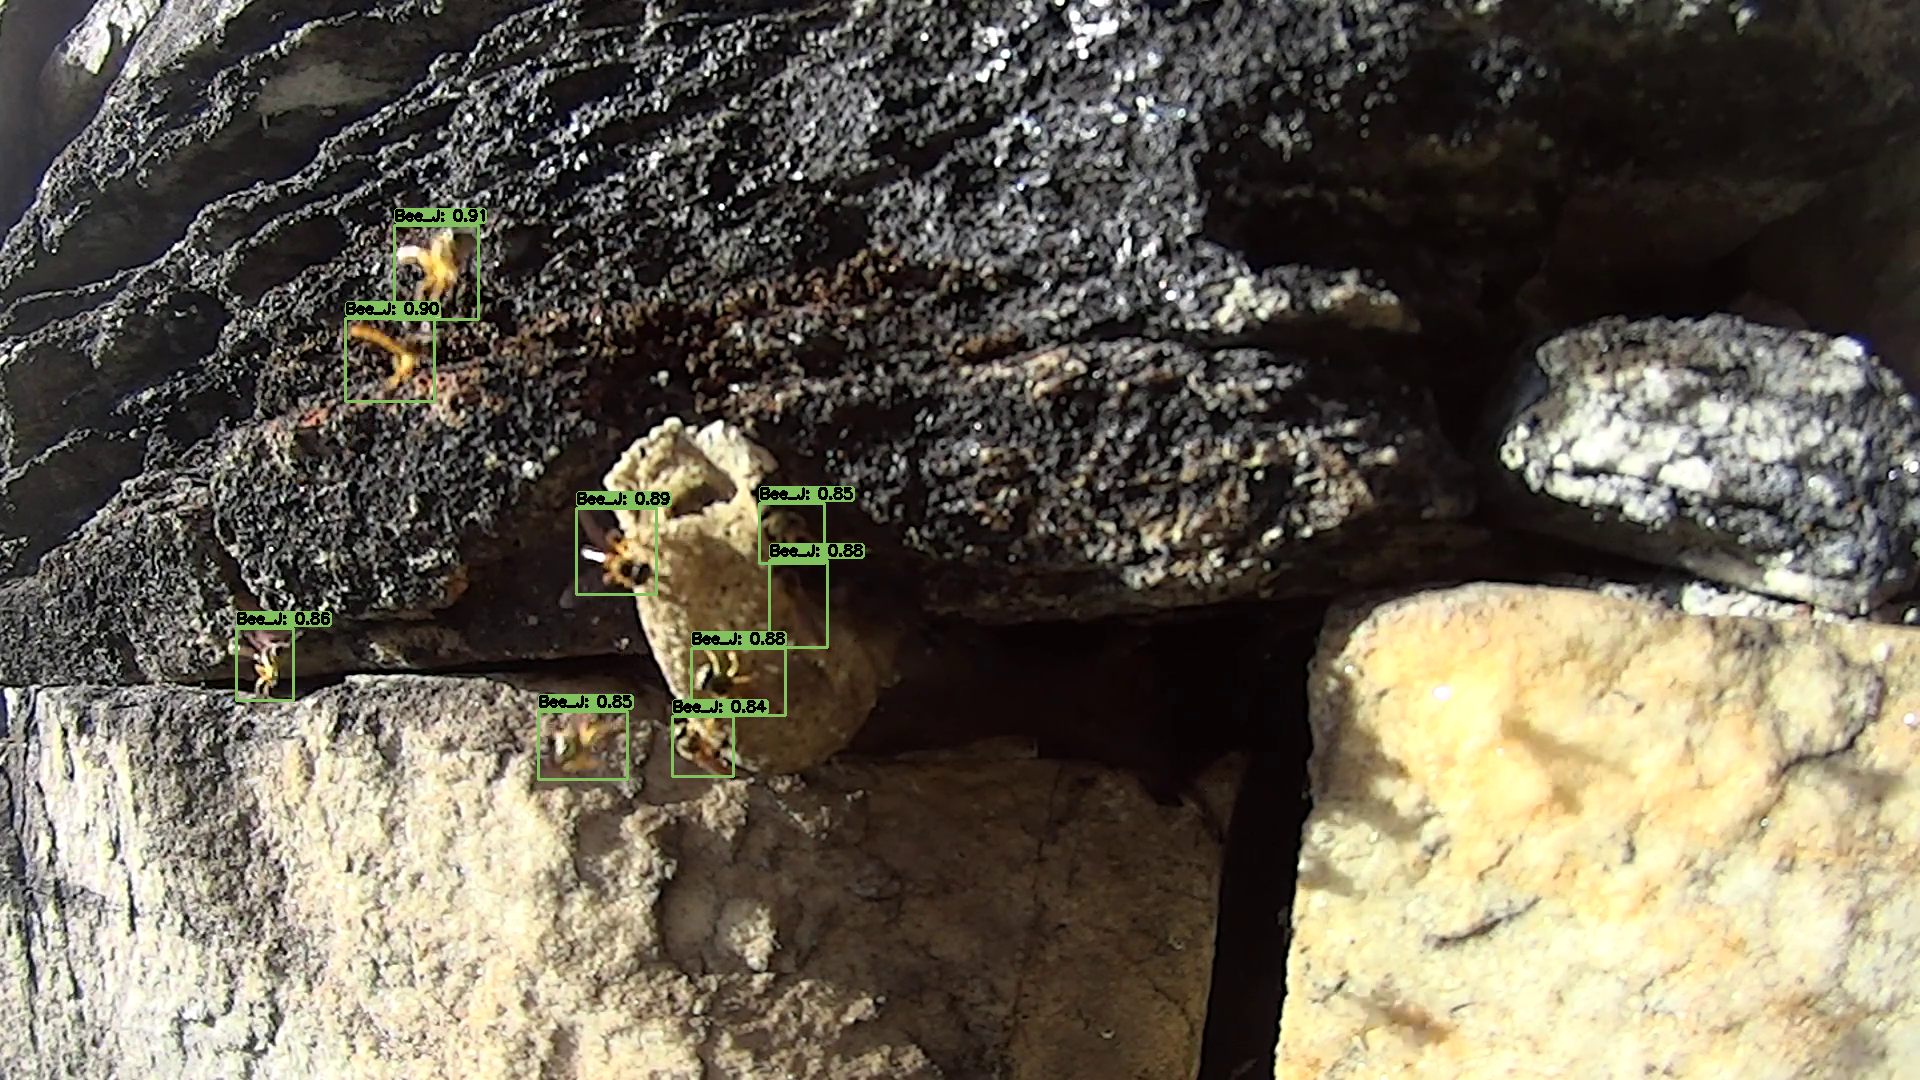

In [14]:
xyxy, confidence, class_id = Y_Inference(SOURCE_IMAGE_PATH)
im = cv2.imread(SOURCE_IMAGE_PATH)
copy = im.copy()
result = Draw_Image(COLORS, copy, xyxy, confidence, class_id)
cv2.imwrite(TARGET_IMAGE_PATH, result)
cv2_imshow(result)

##Euclidian Track - EU

In [15]:
class CentroidTracker(): #Tracking
	#Constructor
	def __init__(self, maxDisappeared):
		#Initialize:
		self.nextObjectID = 0 #object ID
		self.objects = OrderedDict() #Dictionary to track the ID (key) and its centroid (x,y)
		self.disappeared = OrderedDict() #The number of consecutive frames to consider as lost
		self.maxDisappeared = maxDisappeared #Maximum consecutive frames for an object to be considered lost

	#Adds the centroid to the dictionary using the available following ID
	def register(self, centroid):
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	#Deletes an ID record
	def deregister(self, objectID):
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects): #Bounding boxes list
		#In case are no detections, it loops through the IDs, decrementing the missing ones
		if len(rects) == 0:
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				#Checks whether attaining the maximum consecutive frames for a lost object
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			return self.objects

		inputCentroids = np.zeros((len(rects), 2), dtype="int") #Array to store the centroids
		for (i, (x1,y1,x2,y2)) in enumerate(rects):
			cX = int(x1 + (x2 - x1) / 2.0)
			cY = int(y1 + (y2 - y1) / 2.0)
			inputCentroids[i] = (cX, cY)

		#If you are not tracking any objects, record the input centroids
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
		else: #Otherwise, try to match input centroids with existing centroids
			#Gets the set of IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			#Calculate the Euclidean distance between each pair of centroids
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			#Finds the smallest value in each row and sorts its indices based on the minimum values
			rows = D.min(axis=1).argsort()
			#Finds the smallest value in each column and sorts using the rows
			cols = D.argmin(axis=1)[rows]
			#Determines whether to update, register, or unregister an object
			#Tracks which of the row and column indexes have already been examined
			usedRows = set()
			usedCols = set()
			for (row, col) in zip(rows, cols):
				if row in usedRows or col in usedCols:
					continue
				#Gets the object ID for the current row, sets its new centroid, and resets the missing counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0
				usedRows.add(row)
				usedCols.add(col)

			#Calculates row and column indices that have not yet been examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)
			#If the objects' centroids are = or > than the input centroids, check for missing objects
			if D.shape[0] >= D.shape[1]:
				for row in unusedRows:
					#Take the ID on the corresponding line and increment the missing counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					#Checks consecutive frames to register the object as lost
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
			#If the input centroids are > than the object centroids, log the new input centroid
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		return self.objects

In [16]:
def Show_Tracking(objects,frame, color):
	for (objectID, centroid) in objects.items():
		#ID tracking
		fundo = np.full((frame.shape),(0,0,0),dtype = np.uint8)
		textID = "ID_{}".format(objectID)
		cv2.putText(fundo,textID,(centroid[0],centroid[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
		fx,fy,fw,fh = cv2.boundingRect(fundo[:,:,2])
		cv2.rectangle(frame,(fx,fy),(fx+fw,fy+fh),color,-1)
		cv2.rectangle(frame,(fx,fy),(fx+fw,fy+fh),color,3)
		cv2.putText(frame,textID,(centroid[0],centroid[1]),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)
		#Centroide
		#cv2.circle(frame,(centroid[0],centroid[1]),3,color,-1)

##Optical Flow

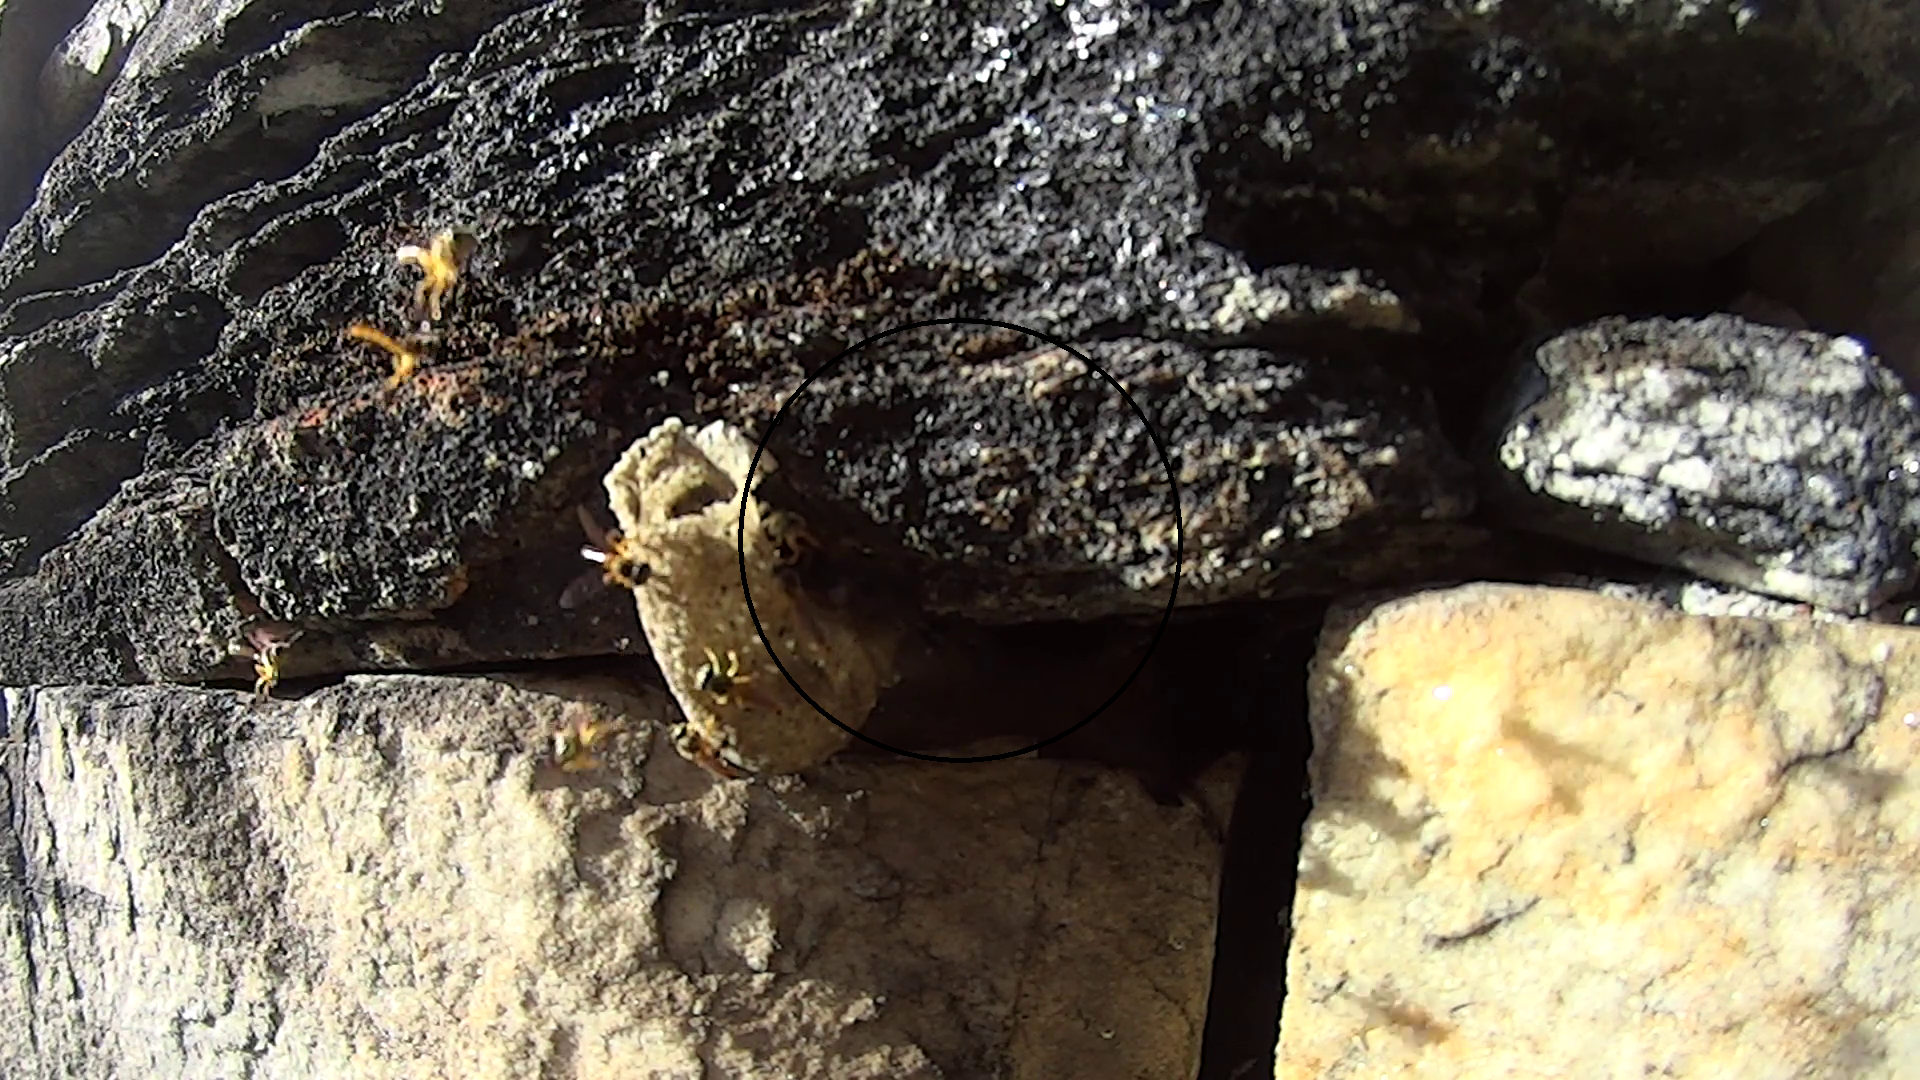

In [17]:
#Define entrada da colmeia
im = cv2.imread(SOURCE_IMAGE_PATH)
#Center: (960,540)
cv2.circle(im,(960,540),220,(0,0,0),3)
cv2_imshow(im)
#001: (810,430),250
#     (940,530),220
#002: (500,850),280
#003: (810,600),250
#004: (890,590),250
#005: (1030,700),180
#006: (370,230),150

In [18]:
#Optical flow
class CentroidFlow():
  #Constructor
	def __init__(self, threshold_dist, IO_center, IO_radius):
		self.threshold_dist = threshold_dist
		self.flag = False
		self.old_objects = []
		self.IO_center = IO_center
		self.IO_radius = IO_radius
		self.IN = []
		self.OUT = []

	def Show_Flow(self, objects, frame, color, classe):
		new_objects = []
		new_ID = []

		for (objectID, centroid) in objects.items():
			new_objects.append(centroid)
			new_ID.append(objectID)

		if self.flag == False:
			self.old_objects =  new_objects
			self.flag = True
			self.mask = np.zeros_like(frame) #Create a mask image for drawing purposes
		else:
			for i,(new_centroid,old_centroid,N_ID) in enumerate(zip(new_objects,self.old_objects,new_ID)):
				Calc_dist = np.linalg.norm(new_centroid - old_centroid)
				if Calc_dist < self.threshold_dist:
					a,b = old_centroid.ravel()
					c,d = new_centroid.ravel()
					self.mask = cv2.line(self.mask, (a,b),(c,d), color, 5)

					D_O_C = trunc(sqrt((self.IO_center[0] - a) ** 2 + (self.IO_center[1] - b) ** 2))
					D_N_C = trunc(sqrt((self.IO_center[0] - c) ** 2 + (self.IO_center[1] - d) ** 2))

					if (D_O_C >= self.IO_radius and D_N_C < self.IO_radius):
						print(str(classe)+' ID_'+str(N_ID)+' entered the hive')
						self.IN.append('ID_'+str(N_ID))
						cv2.putText(frame,str(classe)+' ID_'+str(N_ID)+' entered the hive',(10,30),
							cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)
					elif (D_O_C < self.IO_radius and D_N_C >= self.IO_radius):
						print(str(classe)+' ID_'+str(N_ID)+' came out of the hive')
						self.OUT.append('ID_'+str(N_ID))
						cv2.putText(frame,str(classe)+' ID_'+str(N_ID)+' came out of the hive',(10,30),
							cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0),2)

		self.old_objects =  new_objects

		return self.mask

	def get_in(self):
		return self.IN

	def get_out(self):
		return self.OUT

	def Delete_Flow(self):
	   del(self.old_objects)
	   del(self.flag)

##Duplicates

In [19]:
def remove_dups(lista):
    return list(OrderedDict.fromkeys(lista))

##EU - Experiment

In [20]:
capture = cv2.VideoCapture(SOURCE_VIDEO_PATH)
if not capture.isOpened:
	print('It was not possible to capture the video.')
	exit(0)

#Set the CODEC and create the VideoWriter to save the result
sz = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#sz = (int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)))
fourcc = cv2.VideoWriter_fourcc (*'mp4v')
out = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, 20.0, sz)

ctJ = CentroidTracker(maxDisappeared) #Tracking
cfJ = CentroidFlow(threshold_dist, [810,430], 250) #Optical flow
#IO_center = [810,430] #001, [940,530] #001, [500,850] #002, [810,600] #003, [890,590] #004, [1030,700] #005, [370,230] #006
#IO_Raio = 250 #001, 003, 004; 220 #001; 280 #002; 180 #005; 150 #006
count = 0

while True:
  ret, frame = capture.read()
  if frame is None: break

  xyxy, confidence, class_id = Y_Inference(frame)
  result = Draw_Image(COLORS, frame, xyxy, confidence, class_id)

	#Tracking
  objects0 = ctJ.update(xyxy)
  for id, centroid in objects0.items():
    if id > count: count = id
  Show_Tracking(objects =  objects0,frame = frame,color = (int(COLORS[0][0]), int(COLORS[0][1]), int(COLORS[0][2])))

	#Optical flow
  #001
  cv2.circle(frame,(810,430),250,(0,0,255),3)
  #cv2.circle(frame,(940,530),220,(0,0,255),3)
  #002
  #cv2.circle(frame,(500,850),280,(0,0,255),3)
  #003
  #cv2.circle(frame,(810,600),250,(0,0,255),3)
  #004
  #cv2.circle(frame,(890,590),250,(0,0,255),3)
  #005
  #cv2.circle(frame,(1030,700),180,(0,0,255),3)
  #006
  #cv2.circle(frame,(370,230),150,(0,0,255),3)

  try:
    Mask = cfJ.Show_Flow(objects0, frame, (int(COLORS[0][0]), int(COLORS[0][1]), int(COLORS[0][2])), CLASS_NAMES_DICT[class_id[0]])
  except:
    print("An exception occurred")

  #Uncomment to show trails
  #frame = cv2.add(frame,Mask) #Optical flow

  out.write(frame) #Tracking

print(count, ' Bees in the video')
I = cfJ.get_in
print(len(I()), ' entered the hive: ', I())
O = cfJ.get_out
print(len(O()), ' came out of the hive: ', O())

capture.release()
out.release()
cv2.destroyAllWindows()


0: 480x800 4 Bee_Js, 123.8ms
Speed: 5.6ms preprocess, 123.8ms inference, 16.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 91.2ms
Speed: 6.7ms preprocess, 91.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 91.2ms
Speed: 4.2ms preprocess, 91.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 91.3ms
Speed: 5.1ms preprocess, 91.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 91.2ms
Speed: 4.2ms preprocess, 91.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 80.5ms
Speed: 3.2ms preprocess, 80.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 80.7ms
Speed: 4.0ms preprocess, 80.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.2ms
Speed: 4.3ms preprocess, 79.2ms inference, 1.6ms postprocess per image at shape (1, 3,

Bee_J ID_6 entered the hive



0: 480x800 5 Bee_Js, 78.8ms
Speed: 2.9ms preprocess, 78.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 5.3ms preprocess, 79.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.6ms
Speed: 4.3ms preprocess, 79.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 3.5ms preprocess, 79.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 4.6ms preprocess, 79.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 5.9ms preprocess, 79.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.9ms
Speed: 5.9ms preprocess, 79.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 87.2ms
Speed: 6.7ms preprocess, 87.2ms inference, 2.0ms postprocess per image at shape (1, 3, 48

7  Bees in the video
1  entered the hive:  ['ID_6']
0  came out of the hive:  []


In [21]:
#Remove duplicates
print("No duplicates")
X = remove_dups(I())
print(len(X), ' entered the hive: ', X)
Y = remove_dups(O())
print(len(Y), ' came out of the hive: ', Y)

No duplicates
1  entered the hive:  ['ID_6']
0  came out of the hive:  []


##Byte Track - BT

In [22]:
sys.path.append('/content/ByteTrack')

In [23]:
# To Do:Reduce
def non_max_suppression(
    predictions: np.ndarray, iou_threshold: float = 0.5
) -> np.ndarray:
    """
    Perform Non-Maximum Suppression (NMS) on object detection predictions.
    Args:
        predictions (np.ndarray): An array of object detection predictions in the format of `(x_min, y_min, x_max, y_max, score)` or `(x_min, y_min, x_max, y_max, score, class)`.
        iou_threshold (float, optional): The intersection-over-union threshold to use for non-maximum suppression.
    Returns:
        np.ndarray: A boolean array indicating which predictions to keep after non-maximum suppression.
    Raises:
        AssertionError: If `iou_threshold` is not within the closed range from `0` to `1`.
    """
    assert 0 <= iou_threshold <= 1, (
        f"Value of `iou_threshold` must be in the closed range from 0 to 1, "
        f"{iou_threshold} given."
    )
    rows, columns = predictions.shape

    # add column #5 - category filled with zeros for agnostic nms
    if columns == 5:
        predictions = np.c_[predictions, np.zeros(rows)]

    # sort predictions column #4 - score
    sort_index = np.flip(predictions[:, 4].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 5]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        # drop detections with iou > iou_threshold and same category as current detections
        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

def xywh_to_xyxy(boxes_xywh: np.ndarray) -> np.ndarray:
    xyxy = boxes_xywh.copy()
    xyxy[:, 2] = boxes_xywh[:, 0] + boxes_xywh[:, 2]
    xyxy[:, 3] = boxes_xywh[:, 1] + boxes_xywh[:, 3]
    return xyxy

def _validate_xyxy(xyxy: Any, n: int) -> None:
    is_valid = isinstance(xyxy, np.ndarray) and xyxy.shape == (n, 4)
    if not is_valid:
        raise ValueError("xyxy must be 2d np.ndarray with (n, 4) shape")

def _validate_mask(mask: Any, n: int) -> None:
    is_valid = mask is None or (
        isinstance(mask, np.ndarray) and len(mask.shape) == 3 and mask.shape[0] == n
    )
    if not is_valid:
        raise ValueError("mask must be 3d np.ndarray with (n, W, H) shape")

def _validate_class_id(class_id: Any, n: int) -> None:
    is_valid = class_id is None or (
        isinstance(class_id, np.ndarray) and class_id.shape == (n,)
    )
    if not is_valid:
        raise ValueError("class_id must be None or 1d np.ndarray with (n,) shape")

def _validate_confidence(confidence: Any, n: int) -> None:
    is_valid = confidence is None or (
        isinstance(confidence, np.ndarray) and confidence.shape == (n,)
    )
    if not is_valid:
        raise ValueError("confidence must be None or 1d np.ndarray with (n,) shape")

def _validate_tracker_id(tracker_id: Any, n: int) -> None:
    is_valid = tracker_id is None or (
        isinstance(tracker_id, np.ndarray) and tracker_id.shape == (n,)
    )
    if not is_valid:
        raise ValueError("tracker_id must be None or 1d np.ndarray with (n,) shape")

# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [24]:
# To Do:Reduce
@dataclass
class Detections:
    """
    Data class containing information about the detections in a video frame.
    Attributes:
        xyxy (np.ndarray): An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
        mask: (Optional[np.ndarray]): An array of shape `(n, W, H)` containing the segmentation masks.
        class_id (Optional[np.ndarray]): An array of shape `(n,)` containing the class ids of the detections.
        confidence (Optional[np.ndarray]): An array of shape `(n,)` containing the confidence scores of the detections.
        tracker_id (Optional[np.ndarray]): An array of shape `(n,)` containing the tracker ids of the detections.
    """

    xyxy: np.ndarray
    mask: np.Optional[np.ndarray] = None
    class_id: Optional[np.ndarray] = None
    confidence: Optional[np.ndarray] = None
    tracker_id: Optional[np.ndarray] = None

    def __post_init__(self):
        n = len(self.xyxy)
        _validate_xyxy(xyxy=self.xyxy, n=n)
        _validate_mask(mask=self.mask, n=n)
        _validate_class_id(class_id=self.class_id, n=n)
        _validate_confidence(confidence=self.confidence, n=n)
        _validate_tracker_id(tracker_id=self.tracker_id, n=n)

    def __len__(self):
        """
        Returns the number of detections in the Detections object.
        """
        return len(self.xyxy)

    def __iter__(
        self,
    ) -> Iterator[
        Tuple[
            np.ndarray,
            Optional[np.ndarray],
            Optional[float],
            Optional[int],
            Optional[int],
        ]
    ]:
        """
        Iterates over the Detections object and yield a tuple of `(xyxy, mask, confidence, class_id, tracker_id)` for each detection.
        """
        for i in range(len(self.xyxy)):
            yield (
                self.xyxy[i],
                self.mask[i] if self.mask is not None else None,
                self.confidence[i] if self.confidence is not None else None,
                self.class_id[i] if self.class_id is not None else None,
                self.tracker_id[i] if self.tracker_id is not None else None,
            )

    def __eq__(self, other: Detections):
        return all(
            [
                np.array_equal(self.xyxy, other.xyxy),
                any(
                    [
                        self.mask is None and other.mask is None,
                        np.array_equal(self.mask, other.mask),
                    ]
                ),
                any(
                    [
                        self.class_id is None and other.class_id is None,
                        np.array_equal(self.class_id, other.class_id),
                    ]
                ),
                any(
                    [
                        self.confidence is None and other.confidence is None,
                        np.array_equal(self.confidence, other.confidence),
                    ]
                ),
                any(
                    [
                        self.tracker_id is None and other.tracker_id is None,
                        np.array_equal(self.tracker_id, other.tracker_id),
                    ]
                ),
            ]
        )

    @classmethod
    def from_yolov5(cls, yolov5_results) -> Detections:
        """
        Creates a Detections instance from a YOLOv5 output Detections
        Args:
            yolov5_results (yolov5.models.common.Detections): The output Detections instance from YOLOv5
        Returns:
            Detections: A new Detections object.
        Example:
            ```python
            >>> import torch
            >>> from supervision import Detections
            >>> model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
            >>> results = model(IMAGE)
            >>> detections = Detections.from_yolov5(results)
            ```
        """
        yolov5_detections_predictions = yolov5_results.pred[0].cpu().cpu().numpy()
        return cls(
            xyxy=yolov5_detections_predictions[:, :4],
            confidence=yolov5_detections_predictions[:, 4],
            class_id=yolov5_detections_predictions[:, 5].astype(int),
        )

    @classmethod
    def from_yolov8(cls, yolov8_results) -> Detections:
        """
        Creates a Detections instance from a YOLOv8 output Results
        Args:
            yolov8_results (ultralytics.yolo.engine.results.Results): The output Results instance from YOLOv8
        Returns:
            Detections: A new Detections object.
        Example:
            ```python
            >>> from ultralytics import YOLO
            >>> from supervision import Detections
            >>> model = YOLO('yolov8s.pt')
            >>> yolov8_results = model(IMAGE)[0]
            >>> detections = Detections.from_yolov8(yolov8_results)
            ```
        """
        return cls(
            xyxy=yolov8_results.boxes.xyxy.cpu().numpy(),
            confidence=yolov8_results.boxes.conf.cpu().numpy(),
            class_id=yolov8_results.boxes.cls.cpu().numpy().astype(int),
        )

    @classmethod
    def from_transformers(cls, transformers_results: dict) -> Detections:
        """
        Creates a Detections instance from Object Detection Transformer output Results
        Returns:
            Detections: A new Detections object.
        """
        return cls(
            xyxy=transformers_results["boxes"].cpu().numpy(),
            confidence=transformers_results["scores"].cpu().numpy(),
            class_id=transformers_results["labels"].cpu().numpy().astype(int),
        )

    @classmethod
    def from_detectron2(cls, detectron2_results) -> Detections:
        return cls(
            xyxy=detectron2_results["instances"].pred_boxes.tensor.cpu().numpy(),
            confidence=detectron2_results["instances"].scores.cpu().numpy(),
            class_id=detectron2_results["instances"]
            .pred_classes.cpu()
            .numpy()
            .astype(int),
        )

    @classmethod
    def from_roboflow(cls, roboflow_result: dict, class_list: List[str]) -> Detections:
        xyxy = []
        confidence = []
        class_id = []

        for prediction in roboflow_result["predictions"]:
            x = prediction["x"]
            y = prediction["y"]
            width = prediction["width"]
            height = prediction["height"]
            x_min = x - width / 2
            y_min = y - height / 2
            x_max = x_min + width
            y_max = y_min + height
            xyxy.append([x_min, y_min, x_max, y_max])
            class_id.append(class_list.index(prediction["class"]))
            confidence.append(prediction["confidence"])

        return Detections(
            xyxy=np.array(xyxy),
            confidence=np.array(confidence),
            class_id=np.array(class_id).astype(int),
        )

    @classmethod
    def from_sam(cls, sam_result: List[dict]) -> Detections:
        """
        Creates a Detections instance from Segment Anything Model (SAM) by Meta AI.
        Args:
            sam_result (List[dict]): The output Results instance from SAM
        Returns:
            Detections: A new Detections object.
        Example:
            ```python
            >>> from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
            >>> import supervision as sv
            >>> sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
            >>> mask_generator = SamAutomaticMaskGenerator(sam)
            >>> sam_result = mask_generator.generate(IMAGE)
            >>> detections = sv.Detections.from_sam(sam_result=sam_result)
            ```
        """
        sorted_generated_masks = sorted(
            sam_result, key=lambda x: x["area"], reverse=True
        )

        xywh = np.array([mask["bbox"] for mask in sorted_generated_masks])
        mask = np.array([mask["segmentation"] for mask in sorted_generated_masks])

        return Detections(xyxy=xywh_to_xyxy(boxes_xywh=xywh), mask=mask)

    @classmethod
    def from_coco_annotations(cls, coco_annotation: dict) -> Detections:
        xyxy, class_id = [], []

        for annotation in coco_annotation:
            x_min, y_min, width, height = annotation["bbox"]
            xyxy.append([x_min, y_min, x_min + width, y_min + height])
            class_id.append(annotation["category_id"])

        return cls(xyxy=np.array(xyxy), class_id=np.array(class_id))

    @classmethod
    def empty(cls) -> Detections:
        return cls(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int),
        )

    def get_anchor_coordinates(self, anchor: Position) -> np.ndarray:
        """
        Returns the bounding box coordinates for a specific anchor.
        Args:
            anchor (Position): Position of bounding box anchor for which to return the coordinates.
        Returns:
            np.ndarray: An array of shape `(n, 2)` containing the bounding box anchor coordinates in format `[x, y]`.
        """
        if anchor == Position.CENTER:
            return np.array(
                [
                    (self.xyxy[:, 0] + self.xyxy[:, 2]) / 2,
                    (self.xyxy[:, 1] + self.xyxy[:, 3]) / 2,
                ]
            ).transpose()
        elif anchor == Position.BOTTOM_CENTER:
            return np.array(
                [(self.xyxy[:, 0] + self.xyxy[:, 2]) / 2, self.xyxy[:, 3]]
            ).transpose()

        raise ValueError(f"{anchor} is not supported.")

    def __getitem__(self, index: np.ndarray) -> Detections:
        if isinstance(index, np.ndarray) and (
            index.dtype == bool or index.dtype == int
        ):
            return Detections(
                xyxy=self.xyxy[index],
                mask=self.mask[index]
                if self.mask is not None
                else None,
                confidence=self.confidence[index]
                if self.confidence is not None
                else None,
                class_id=self.class_id[index] if self.class_id is not None else None,
                tracker_id=self.tracker_id[index]
                if self.tracker_id is not None
                else None,
            )
        raise TypeError(
            f"Detections.__getitem__ not supported for index of type {type(index)}."
        )

    @property
    def area(self) -> np.ndarray:
        """
        Calculate the area of each detection in the set of object detections. If masks field is defined property
        returns are of each mask. If only box is given property return area of each box.
        Returns:
          np.ndarray: An array of floats containing the area of each detection in the format of `(area_1, area_2, ..., area_n)`, where n is the number of detections.
        """
        if self.mask is not None:
            return np.array([np.sum(mask) for mask in self.mask])
        else:
            return self.box_area

    @property
    def box_area(self) -> np.ndarray:
        """
        Calculate the area of each bounding box in the set of object detections.
        Returns:
            np.ndarray: An array of floats containing the area of each bounding box in the format of `(area_1, area_2, ..., area_n)`, where n is the number of detections.
        """
        return (self.xyxy[:, 3] - self.xyxy[:, 1]) * (self.xyxy[:, 2] - self.xyxy[:, 0])

    def with_nms(
        self, threshold: float = 0.5, class_agnostic: bool = False
    ) -> Detections:
        """
        Perform non-maximum suppression on the current set of object detections.
        Args:
            threshold (float, optional): The intersection-over-union threshold to use for non-maximum suppression. Defaults to 0.5.
            class_agnostic (bool, optional): Whether to perform class-agnostic non-maximum suppression. If True, the class_id of each detection will be ignored. Defaults to False.
        Returns:
            Detections: A new Detections object containing the subset of detections after non-maximum suppression.
        Raises:
            AssertionError: If `confidence` is None and class_agnostic is False. If `class_id` is None and class_agnostic is False.
        """
        if len(self) == 0:
            return self

        assert (
            self.confidence is not None
        ), f"Detections confidence must be given for NMS to be executed."

        if class_agnostic:
            predictions = np.hstack((self.xyxy, self.confidence.reshape(-1, 1)))
            indices = non_max_suppression(
                predictions=predictions, iou_threshold=threshold
            )
            return self[indices]

        assert self.class_id is not None, (
            f"Detections class_id must be given for NMS to be executed. If you intended to perform class agnostic "
            f"NMS set class_agnostic=True."
        )

        predictions = np.hstack(
            (self.xyxy, self.confidence.reshape(-1, 1), self.class_id.reshape(-1, 1))
        )
        indices = non_max_suppression(predictions=predictions, iou_threshold=threshold)
        return self[indices]

In [25]:
# To Do:Reduce
class Position(Enum):
    CENTER = "CENTER"
    BOTTOM_CENTER = "BOTTOM_CENTER"

    @classmethod
    def list(cls):
        return list(map(lambda c: c.value, cls))

@dataclass
class Point:
    x: float
    y: float

    def as_xy_int_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)

    def as_xy_float_tuple(self) -> Tuple[float, float]:
        return self.x, self.y

@dataclass
class Vector:
    start: Point
    end: Point

    def is_in(self, point: Point) -> bool:
        v1 = Vector(self.start, self.end)
        v2 = Vector(self.start, point)
        cross_product = (v1.end.x - v1.start.x) * (v2.end.y - v2.start.y) - (
            v1.end.y - v1.start.y
        ) * (v2.end.x - v2.start.x)
        return cross_product < 0

@dataclass
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    def pad(self, padding) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2 * padding,
            height=self.height + 2 * padding,
        )

##BT - Experiment

In [29]:
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())

capture = cv2.VideoCapture(SOURCE_VIDEO_PATH)
if not capture.isOpened:
	print('Não foi possivel capturar o video')
	exit(0)

#Set the CODEC and create the VideoWriter to save the result
sz = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#sz = (int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)),int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)))
fourcc = cv2.VideoWriter_fourcc (*'mp4v')
out = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, 20.0, sz)

cfJ = CentroidFlow(threshold_dist, [810,430], 250) #Optical flow
#IO_center = [810,430] #001, [940,530] #001, [500,850] #002, [810,600] #003, [890,590] #004, [1030,700] #005, [370,230] #006
#IO_Raio = 250 #001, 003, 004; 220 #001; 280 #002; 180 #005; 150 #006
count = 0
idi = 10000
id_BT = []

while True:
  ret, frame = capture.read()
  if frame is None: break

  xyxy, confidence, class_id = Y_Inference(frame)
  result = Draw_Image(COLORS, frame, xyxy, confidence, class_id)

  #Tracking
  detections = Detections(xyxy=xyxy, confidence=confidence, class_id=class_id)
  output_results=detections2boxes(detections=detections)
  tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
  tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
  detections.tracker_id = np.array(tracker_id)

  od = OrderedDict()
  inputCentroids = np.zeros((len(detections.xyxy), 2), dtype="int")
  if len(detections.xyxy) == len(detections.tracker_id):
    for (i, (x1,y1,x2,y2)) in enumerate(detections.xyxy):
      cX = int(x1 + (x2 - x1) / 2.0)
      cY = int(y1 + (y2 - y1) / 2.0)
      od[detections.tracker_id[i]] = np.asarray([cX, cY])
      inputCentroids[i] = [cX, cY]

    Show_Tracking(objects =  od,frame = frame,color = (int(COLORS[0][0]), int(COLORS[0][1]), int(COLORS[0][2])))

  for id, centroid in od.items():
    if id != None and id > count:
       count = id
       if id < idi: idi = id
    if id in id_BT: T = 0
    elif id != None: id_BT.append(id)

  #Optical flow
  #001
  cv2.circle(frame,(810,430),250,(0,0,255),3)
  #cv2.circle(frame,(940,530),220,(0,0,255),3)
  #002
  #cv2.circle(frame,(500,850),280,(0,0,255),3)
  #003
  #cv2.circle(frame,(810,600),250,(0,0,255),3)
  #004
  #cv2.circle(frame,(890,590),250,(0,0,255),3)
  #005
  #cv2.circle(frame,(1030,700),180,(0,0,255),3)
  #006
  #cv2.circle(frame,(370,230),150,(0,0,255),3)

  try:
    Mask = cfJ.Show_Flow(od, frame, (int(COLORS[0][0]), int(COLORS[0][1]), int(COLORS[0][2])), CLASS_NAMES_DICT[class_id[0]])
  except:
    print("An exception occurred")

  #Uncomment to show trails
  #frame = cv2.add(frame,Mask) #Optical flow

  out.write(frame) #Tracking

print(count - idi, " Bees id's in the video")
print(len(id_BT), ' Bees in the video: ', id_BT)
I = cfJ.get_in
print(len(I()), ' entered the hive: ', I())
O = cfJ.get_out
print(len(O()), ' came out of the hive: ', O())

capture.release()
out.release()
cv2.destroyAllWindows()


0: 480x800 4 Bee_Js, 92.4ms
Speed: 4.0ms preprocess, 92.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 82.4ms
Speed: 4.4ms preprocess, 82.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 82.2ms
Speed: 4.5ms preprocess, 82.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 82.4ms
Speed: 4.1ms preprocess, 82.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.0ms
Speed: 4.3ms preprocess, 79.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.0ms
Speed: 4.0ms preprocess, 79.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.0ms
Speed: 7.8ms preprocess, 79.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.2ms
Speed: 5.4ms preprocess, 79.2ms inference, 2.4ms postprocess per image at shape (1, 3, 48

Bee_J ID_298 entered the hive



0: 480x800 5 Bee_Js, 79.1ms
Speed: 4.1ms preprocess, 79.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.0ms
Speed: 5.7ms preprocess, 79.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.3ms
Speed: 4.5ms preprocess, 79.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.0ms
Speed: 3.5ms preprocess, 79.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 4.8ms preprocess, 79.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.1ms
Speed: 4.5ms preprocess, 79.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 79.6ms
Speed: 4.2ms preprocess, 79.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 4 Bee_Js, 80.1ms
Speed: 4.7ms preprocess, 80.1ms inference, 1.6ms postprocess per image at shape (1, 3, 48

10  Bees id's in the video
8  Bees in the video:  [290, 291, 292, 293, 295, 296, 298, 300]
1  entered the hive:  ['ID_298']
0  came out of the hive:  []


In [30]:
#Remove duplicates
print("No duplicates")
X = remove_dups(I())
print(len(X), ' entered the hive: ', X)
Y = remove_dups(O())
print(len(Y), ' came out of the hive: ', Y)

No duplicates
1  entered the hive:  ['ID_298']
0  came out of the hive:  []
